## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

"""
建立實驗組合
"""
optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]
reduce_lr_factor = [0.99, 0.5, 0.1]
redice_lr_patient = [3,5,10]

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
import itertools

"""
以迴圈方式遍歷組合來訓練模型
"""
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.99, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 17s 332us/step - loss: 1.3102 - acc: 0.5416 - val_loss: 1.4919 - val_acc: 0.4785
Epoch 12/25
50000/50000 [==============================] - 15s 302us/step - loss: 1.2870 - acc: 0.5516 - val_loss: 1.5066 - val_acc: 0.4762
Epoch 13/25
50000/50000 [==============================] - 14s 276us/step - loss: 1.2638 - acc: 0.5598 - val_loss: 1.4851 - val_acc: 0.4817
Epoch 14/25
50000/50000 [==============================] - 15s 298us/step - loss: 1.2407 - acc: 0.5704 - val_loss: 1.4631 - val_acc: 0.4876
Epoch 15/25
50000/50000 [==============================] - 17s 342us/step - loss: 1.2204 - acc: 0.5762 - val_loss: 1.4754 - val_acc: 0.4842
Epoch 16/25
50000/50000 [==============================] - 15s 296us/step - loss: 1.1999 - acc: 0.5847 - val_loss: 1.4527 - val_acc: 0.4925
Epoch 17/25
50000/50000 [==============================] - 16s 323us/step - loss: 1.1811 - acc: 0.5926 - val_loss: 1.4516 - val_acc: 0.4908
Epoch 18/25
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 16s 310us/step - loss: 2.2111 - acc: 0.2684 - val_loss: 2.0525 - val_acc: 0.3194
Epoch 2/25
50000/50000 [==============================] - 12s 231us/step - loss: 1.7697 - acc: 0.3859 - val_loss: 1.8786 - val_acc: 0.3605
Epoch 3/25
50000/50000 [==============================] - 12s 231us/step - loss: 1.6361 - acc: 0.4262 - val_loss: 1.6979 - val_acc: 0.4121
Epoch 4/25
50000/50000 [==============================] - 12s 246us/step - loss: 1.5606 - acc: 0.4524 - val_loss: 1.6584 - val_acc: 0.4232
Epoch 5/25
50000/50000 [==============================] - 14s 273us/step - loss: 1.5065 - acc: 0.4729 - val_loss: 1.6224 - val_acc: 0.4322
Epoch 6/25
50000/50000 [==============================] - 12s 231us/step - loss: 1.4620 - acc: 0.4874 - val_loss: 1.5868 - val_acc: 0.4422
Epoch 7/25
50000/50000 [==============================] - 12s 231us/step - loss: 1.4247 - acc: 0.5032 - val_loss: 1.

Epoch 23/25
50000/50000 [==============================] - 11s 224us/step - loss: 1.2381 - acc: 0.5707 - val_loss: 1.4936 - val_acc: 0.4805
Epoch 24/25
50000/50000 [==============================] - 11s 226us/step - loss: 1.2257 - acc: 0.5760 - val_loss: 1.4901 - val_acc: 0.4831
Epoch 25/25
50000/50000 [==============================] - 11s 225us/step - loss: 1.2123 - acc: 0.5803 - val_loss: 1.4857 - val_acc: 0.4837
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
___________________________________________________________

50000/50000 [==============================] - 12s 237us/step - loss: 1.4515 - acc: 0.4923 - val_loss: 1.5893 - val_acc: 0.4401
Epoch 11/25
50000/50000 [==============================] - 11s 224us/step - loss: 1.4286 - acc: 0.4997 - val_loss: 1.5628 - val_acc: 0.4534
Epoch 12/25
50000/50000 [==============================] - 11s 229us/step - loss: 1.4061 - acc: 0.5077 - val_loss: 1.5609 - val_acc: 0.4587
Epoch 13/25
50000/50000 [==============================] - 11s 223us/step - loss: 1.3878 - acc: 0.5143 - val_loss: 1.5479 - val_acc: 0.4643
Epoch 14/25
50000/50000 [==============================] - 11s 224us/step - loss: 1.3700 - acc: 0.5215 - val_loss: 1.5356 - val_acc: 0.4680
Epoch 15/25
50000/50000 [==============================] - 11s 221us/step - loss: 1.3527 - acc: 0.5281 - val_loss: 1.5319 - val_acc: 0.4673
Epoch 16/25
50000/50000 [==============================] - 11s 222us/step - loss: 1.3360 - acc: 0.5322 - val_loss: 1.5226 - val_acc: 0.4718
Epoch 17/25
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 16s 316us/step - loss: 2.3732 - acc: 0.2315 - val_loss: 2.3349 - val_acc: 0.2811
Epoch 2/25
50000/50000 [==============================] - 11s 227us/step - loss: 1.9040 - acc: 0.3446 - val_loss: 1.9347 - val_acc: 0.3557
Epoch 3/25
50000/50000 [==============================] - 11s 223us/step - loss: 1.7573 - acc: 0.3875 - val_loss: 1.8037 - val_acc: 0.3758
Epoch 4/25
50000/50000 [==============================] - 11s 223us/step - loss: 1.6777 - acc: 0.4108 - val_loss: 1.7313 - val_acc: 0.3975
Epoch 5/25
50000/50000 [==============================] - 11s 223us/step - loss: 1.6226 - acc: 0.4290 - val_loss: 1.6862 - val_acc: 0.4127
Epoch 6/25
50000/50000 [==============================] - 11s 225us/step - loss: 1.5787 - acc: 0.4454 - val_loss: 1.6624 - val_acc: 0.4198
Epoch 7/25
50000/50000 [==============================] - 12s 231us/step - loss: 1.5431 - acc: 0.4582 - val_loss: 1.

50000/50000 [==============================] - 12s 234us/step - loss: 0.4925 - acc: 0.8333 - val_loss: 2.0198 - val_acc: 0.4627
Epoch 23/25
50000/50000 [==============================] - 11s 228us/step - loss: 0.4533 - acc: 0.8481 - val_loss: 1.9918 - val_acc: 0.4702
Epoch 24/25
50000/50000 [==============================] - 11s 228us/step - loss: 0.4179 - acc: 0.8616 - val_loss: 1.9532 - val_acc: 0.4663

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0009605961316265165.
Epoch 25/25
50000/50000 [==============================] - 11s 228us/step - loss: 0.3938 - acc: 0.8693 - val_loss: 2.1682 - val_acc: 0.4501
Numbers of exp: 10, reduce_factor: 0.99, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)        

50000/50000 [==============================] - 14s 272us/step - loss: 1.2453 - acc: 0.5565 - val_loss: 1.4718 - val_acc: 0.4789
Epoch 8/25
50000/50000 [==============================] - 14s 271us/step - loss: 1.2018 - acc: 0.5750 - val_loss: 1.6139 - val_acc: 0.4451
Epoch 9/25
50000/50000 [==============================] - 14s 286us/step - loss: 1.1601 - acc: 0.5897 - val_loss: 1.6007 - val_acc: 0.4436
Epoch 10/25
50000/50000 [==============================] - 14s 277us/step - loss: 1.1213 - acc: 0.6018 - val_loss: 1.5529 - val_acc: 0.4597
Epoch 11/25
50000/50000 [==============================] - 18s 362us/step - loss: 1.0849 - acc: 0.6162 - val_loss: 1.7621 - val_acc: 0.4219
Epoch 12/25
50000/50000 [==============================] - 15s 290us/step - loss: 1.0475 - acc: 0.6284 - val_loss: 1.4739 - val_acc: 0.4822
Epoch 13/25
50000/50000 [==============================] - 14s 282us/step - loss: 1.0143 - acc: 0.6416 - val_loss: 1.4296 - val_acc: 0.4964
Epoch 14/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 26s 527us/step - loss: 2.0061 - acc: 0.3273 - val_loss: 1.8992 - val_acc: 0.3488
Epoch 2/25
50000/50000 [==============================] - 17s 338us/step - loss: 1.6397 - acc: 0.4265 - val_loss: 1.6854 - val_acc: 0.4056
Epoch 3/25
50000/50000 [==============================] - 18s 367us/step - loss: 1.5438 - acc: 0.4590 - val_loss: 1.6544 - val_acc: 0.4120
Epoch 4/25
50000/50000 [==============================] - 12s 248us/step - loss: 1.4804 - acc: 0.4811 - val_loss: 1.6216 - val_acc: 0.4204
Epoch 5/25
50000/50000 [==============================] - 13s 264us/step - loss: 1.4342 - acc: 0.4979 - val_loss: 1.5869 - val_acc: 0.4361
Epoch 6/25
50000/50000 [==============================] - 19s 373us/step - loss: 1.3982 - acc: 0.5089 - val_loss: 1.5602 - val_acc: 0.4488
Epoch 7/25
50000/50000 [==============================] - 13s 257us/step - loss: 1.3656 - acc: 0.5243 - val_loss: 1.

50000/50000 [==============================] - 11s 229us/step - loss: 1.1133 - acc: 0.6191 - val_loss: 1.4446 - val_acc: 0.4936
Epoch 24/25
50000/50000 [==============================] - 11s 229us/step - loss: 1.1018 - acc: 0.6234 - val_loss: 1.4388 - val_acc: 0.4917
Epoch 25/25
50000/50000 [==============================] - 12s 233us/step - loss: 1.0906 - acc: 0.6277 - val_loss: 1.4368 - val_acc: 0.4973
Numbers of exp: 15, reduce_factor: 0.10, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
hidde

50000/50000 [==============================] - 11s 230us/step - loss: 1.8410 - acc: 0.3664 - val_loss: 1.9005 - val_acc: 0.3495
Epoch 10/25
50000/50000 [==============================] - 13s 270us/step - loss: 1.8214 - acc: 0.3719 - val_loss: 1.8843 - val_acc: 0.3542
Epoch 11/25
50000/50000 [==============================] - 13s 262us/step - loss: 1.8046 - acc: 0.3764 - val_loss: 1.8684 - val_acc: 0.3572
Epoch 12/25
50000/50000 [==============================] - 12s 247us/step - loss: 1.7892 - acc: 0.3809 - val_loss: 1.8538 - val_acc: 0.3613
Epoch 13/25
50000/50000 [==============================] - 13s 256us/step - loss: 1.7738 - acc: 0.3855 - val_loss: 1.8421 - val_acc: 0.3694
Epoch 14/25
50000/50000 [==============================] - 12s 246us/step - loss: 1.7611 - acc: 0.3897 - val_loss: 1.8315 - val_acc: 0.3701
Epoch 15/25
50000/50000 [==============================] - 16s 322us/step - loss: 1.7492 - acc: 0.3937 - val_loss: 1.8221 - val_acc: 0.3752
Epoch 16/25
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 18s 362us/step - loss: 1.8520 - acc: 0.3656 - val_loss: 2.0560 - val_acc: 0.3145
Epoch 2/25
50000/50000 [==============================] - 12s 231us/step - loss: 1.5410 - acc: 0.4539 - val_loss: 1.8641 - val_acc: 0.3531
Epoch 3/25
50000/50000 [==============================] - 11s 228us/step - loss: 1.4319 - acc: 0.4937 - val_loss: 2.2319 - val_acc: 0.2879
Epoch 4/25
50000/50000 [==============================] - 11s 228us/step - loss: 1.3462 - acc: 0.5225 - val_loss: 1.9089 - val_acc: 0.3515
Epoch 5/25
50000/50000 [==============================] - 12s 233us/step - loss: 1.2881 - acc: 0.5467 - val_loss: 1.9612 - val_acc: 0.3440

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0009900000470224768.
Epoch 6/25
50000/50000 [==============================] - 11s 228us/step - loss: 1.2216 - acc: 0.5690 - val_loss: 1.9049 - val_acc: 0.3682
Epoch 7/25
50000/50000 [===========

50000/50000 [==============================] - 12s 242us/step - loss: 0.7341 - acc: 0.7453 - val_loss: 1.9309 - val_acc: 0.4325
Epoch 20/25
50000/50000 [==============================] - 12s 233us/step - loss: 0.7023 - acc: 0.7574 - val_loss: 2.0376 - val_acc: 0.3985
Epoch 21/25
50000/50000 [==============================] - 12s 234us/step - loss: 0.6745 - acc: 0.7680 - val_loss: 2.0396 - val_acc: 0.4149
Epoch 22/25
50000/50000 [==============================] - 12s 232us/step - loss: 0.6482 - acc: 0.7763 - val_loss: 1.9648 - val_acc: 0.4386

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0009227448242017999.
Epoch 23/25
50000/50000 [==============================] - 12s 234us/step - loss: 0.6223 - acc: 0.7865 - val_loss: 2.2086 - val_acc: 0.3938
Epoch 24/25
50000/50000 [==============================] - 12s 234us/step - loss: 0.5955 - acc: 0.7942 - val_loss: 2.0512 - val_acc: 0.4133
Epoch 25/25
50000/50000 [==============================] - 12s 234us/step - loss: 0.5698 - 

50000/50000 [==============================] - 11s 230us/step - loss: 1.2750 - acc: 0.5483 - val_loss: 2.0874 - val_acc: 0.3439

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00045675868750549853.
Epoch 6/25
50000/50000 [==============================] - 11s 228us/step - loss: 1.1452 - acc: 0.5992 - val_loss: 1.9126 - val_acc: 0.3625
Epoch 7/25
50000/50000 [==============================] - 11s 230us/step - loss: 1.0951 - acc: 0.6179 - val_loss: 1.5890 - val_acc: 0.4445
Epoch 8/25
50000/50000 [==============================] - 11s 227us/step - loss: 1.0546 - acc: 0.6324 - val_loss: 1.6277 - val_acc: 0.4451
Epoch 9/25
50000/50000 [==============================] - 11s 229us/step - loss: 1.0189 - acc: 0.6447 - val_loss: 1.5741 - val_acc: 0.4787
Epoch 10/25
50000/50000 [==============================] - 11s 227us/step - loss: 0.9822 - acc: 0.6590 - val_loss: 1.5898 - val_acc: 0.4483
Epoch 11/25
50000/50000 [==============================] - 11s 230us/step - loss: 0.9529 - acc

50000/50000 [==============================] - 11s 227us/step - loss: 1.2230 - acc: 0.5789 - val_loss: 1.5216 - val_acc: 0.4650
Numbers of exp: 23, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_70 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_71 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense

50000/50000 [==============================] - 11s 229us/step - loss: 1.4410 - acc: 0.4967 - val_loss: 1.5876 - val_acc: 0.4449
Epoch 13/25
50000/50000 [==============================] - 11s 228us/step - loss: 1.4174 - acc: 0.5065 - val_loss: 1.5755 - val_acc: 0.4510
Epoch 14/25
50000/50000 [==============================] - 11s 227us/step - loss: 1.3975 - acc: 0.5126 - val_loss: 1.5649 - val_acc: 0.4563
Epoch 15/25
50000/50000 [==============================] - 11s 226us/step - loss: 1.3778 - acc: 0.5213 - val_loss: 1.5580 - val_acc: 0.4548
Epoch 16/25
50000/50000 [==============================] - 11s 226us/step - loss: 1.3607 - acc: 0.5279 - val_loss: 1.5479 - val_acc: 0.4613
Epoch 17/25
50000/50000 [==============================] - 11s 227us/step - loss: 1.3431 - acc: 0.5342 - val_loss: 1.5351 - val_acc: 0.4614
Epoch 18/25
50000/50000 [==============================] - 12s 235us/step - loss: 1.3263 - acc: 0.5404 - val_loss: 1.5317 - val_acc: 0.4670
Epoch 19/25
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 19s 389us/step - loss: 2.2853 - acc: 0.2449 - val_loss: 2.1597 - val_acc: 0.2983
Epoch 2/25
50000/50000 [==============================] - 11s 229us/step - loss: 1.9335 - acc: 0.3345 - val_loss: 1.9670 - val_acc: 0.3428
Epoch 3/25
50000/50000 [==============================] - 12s 233us/step - loss: 1.7992 - acc: 0.3788 - val_loss: 1.8639 - val_acc: 0.3651
Epoch 4/25
50000/50000 [==============================] - 11s 228us/step - loss: 1.7150 - acc: 0.4031 - val_loss: 1.7858 - val_acc: 0.3880
Epoch 5/25
50000/50000 [==============================] - 12s 230us/step - loss: 1.6532 - acc: 0.4235 - val_loss: 1.7460 - val_acc: 0.3906
Epoch 6/25
50000/50000 [==============================] - 11s 229us/step - loss: 1.6064 - acc: 0.4389 - val_loss: 1.6946 - val_acc: 0.4077
Epoch 7/25
50000/50000 [==============================] - 11s 228us/step - loss: 1.5666 - acc: 0.4529 - val_loss: 1.

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

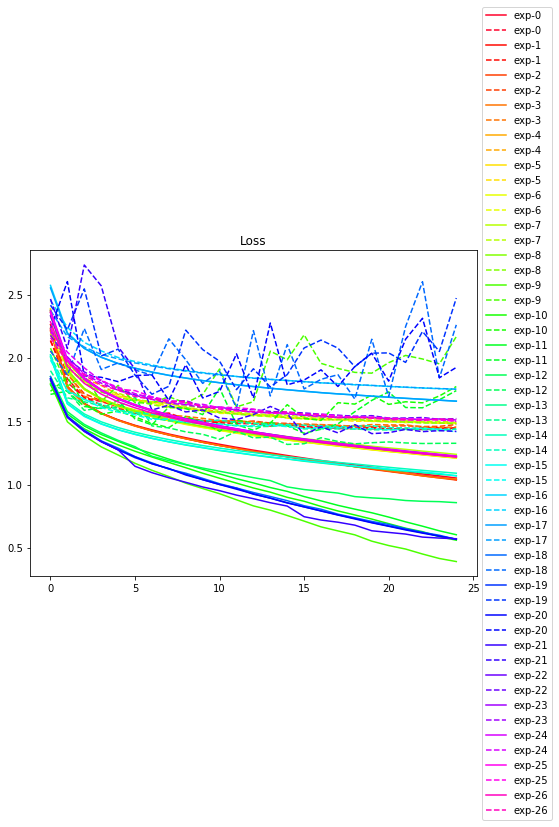

In [10]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

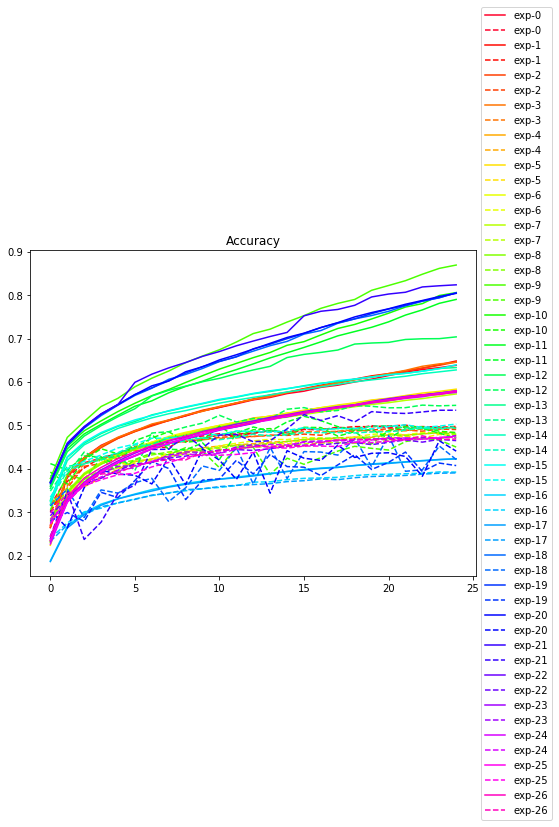

In [11]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()